# Heat Smart Orkney Business Report

***

**Table of Content**

<ol>
    <li><a href="#section_1">Summary</a></li>
    <li><a href="#section_2">Introduction</a></li>
    <li><a href="#section_3">Understanding Curtailment in Orkney</a></li>
    <li><a href="#section_4">Demand Response Evaluation</a></li>
    <li><a href="#section_5">Business Plan</a></li>
    <li><a href="#section_6">Potential Alternatives</a></li>
    <li><a href="#section_7">Conclusion</a></li>
    <li><a href="#appendices">Appendices</a></li>
    <li><a href="#references">References</a></li>
</ol>

<a id="section_1"></a>

## I. Summary

In this report, we present a business case featuring wind energy market in Orkney. Orkney is one of the pioneers of renewable energy in the United Kingdom, specifically wind energy. Given the existing wind turbine farms and infrastructure available in Orkney, there is a large potential market to tap on. Currently, Orkney experiences energy curtailment issue due to their low demand level. As a pioneer of smart demand response technology, Kaluza has a potential to enter the market and introduce our demand response technology to curb this curtailment.

Based on this premise, we perform exploratory data analysis on Okrney's demand level and potential wind power generation to understand the level of curtailment in the market and find that 70.8% of wind energy are currently being curtailed. By offering our service to implement demand response (DR) technology, we can help Orkney to reduce curtailment by a maximum of 15.4%.

To enter the market, we need to allocate a budget for marketing and promotion as well as requesting government subsidy for promoting improvements in the renewable energy sector. Our business plan aims for DR penetration rate of 90%, while providing free electricity to the households for approximately 90 days. From our estimate, this would incur a net cost £2.4M with breakeven period of 271 days, in which after 271 days we can potentially make profit of £9.1K per day.

<a id='section_2'></a>

## II. Introduction

The case study revolves around energy curtailment in Orkney, specifically the one generated from wind turbines. Curtailment occurs in order to balance the supply and demand of the energy market. However, unlike fossil fuels, wind energy is not available on-demand and there is an opportunity cost entailed in curtailing wind turbines.

Currently, this issue of curtailment leads to a significant revenue loss for wind turbine owners. To address this problem, we are looking into implementing  demand response (DR) schemes for storage heaters and hot-water cylinders in households as our main potential solution.

### Demographics

According to National Records of Scotland [$^{[1]}$](#ref_1), Orkney (2017) has the following demographics, which we will base our assumptions on:
* Population size: 21,929
* Number of households: 10,385
* Average occupant per household: 2.11

### Energy Profile

According to the Department of Business, Energy & Industrial Strategy [$^{[2]}$](#ref_1), energy consumption from electricity in Orkney (2017) comprises of 59.2% (81.8GWh) domestic and 40.8% (56.3GWh) industrial sector.

<a id="section_3"></a>

## III. Understanding Curtailment in Orkney

To evaluate the effectiveness of the DR scheme, we need to benchmark it against a baseline scenario. In this case, we will estimate the current level of curtailment as the baseline. This enables us to (i) understand the scale of the current curtailment issue and (ii) estimate the extent of the impact of DR schemes.

Curtailment is calculated by substracting the total energy consumption from the potential maximum level of energy generated. Given that Orkney is a net energy exporter, connected to UK mainland through 40MW transmission cable, we can assume that the excess energy generated is exported.

$$
\therefore \text{Curtailed = Potential - Consumed - Exported}
$$

Exported energy can simply be calculated by assuming a maximum power transmission through the 40MW cable. Hence, we will derive the following key information from the available dataset: 

1. The overall **household energy consumption** from electricity usage
2. The **maximum potential energy** generated by the wind turbine

In [1]:
# Load relevant libraries for data analysis and explorations
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker

IPython_default = plt.rcParams.copy()
plt.style.use('ggplot')
%matplotlib inline
default_color="#1f77b4"

# Read dataset: (i) demand and (ii) turbine telemetry
demand_df = pd.read_csv("Residential_demand.csv", encoding="utf-8", parse_dates=['Timestamp'])
turbine_df = pd.read_csv("Turbine_telemetry.csv", encoding="utf-8", parse_dates=['Timestamp'])

<a id="section_2_1"></a>

### 1. Household Energy Consumption

To approach this, we will look at the various energy demand statistics and pattern from the household demand data. The data was retreived from households that have been installed with our smart meters.

If we look briefly into the summary statistics in table 1 below, we observe the following:

* Average demand: 0.22 kW / household
* Min-Max demand: 0.09kW - 0.51 kW / household

We also observe a potential dirty data that we may need to take note, as the maximum household in the data is indicated as 30,037 while the official statistics recorded 10,385 households. This may be due to duplicate counting of the same household IDs when aggregating the data points ([appendix 1](#appendix_1) | [appendix 2](#appendix_2)).

In [2]:
# Brief overview of the Demand dataframe and the summary statistics
print("\033[1m\033[4mTable 1. Summary statistics of household demand data\033[0m")
with pd.option_context('float_format', '{:,.2f}'.format):
    display(demand_df.describe().T)

Table 1. Summary statistics of household demand data


,count,mean,std,min,25%,50%,75%,max
Demand_mean_kw,"17,568.00",0.22,0.09,0.09,0.14,0.21,0.27,0.51
N_households,"17,568.00","8,630.64","2,999.14","5,406.00","6,781.00","8,190.50","9,652.00","30,037.00"


In [3]:
# Extract datetime information from `Timestamp` column
demand_df['date'] = demand_df['Timestamp'].dt.date
demand_df['month_of_year'] = demand_df['Timestamp'].dt.month
demand_df['month_abbr'] = demand_df['month_of_year'].apply(lambda x: calendar.month_abbr[x])
demand_df['day_of_week'] = demand_df['Timestamp'].dt.day_name()
demand_df['time_of_day'] = demand_df['Timestamp'].dt.hour + demand_df['Timestamp'].dt.minute / 60

As we plot the mean demand in half-hourly, daily and monthly (boxplot) in figure below, we observe several patterns in the energy demand profile of Orkney's households:

* Demand fluctuates in **very high variance** even within the day from **around 0.1kW up to 0.5kW**
* However, on average, the base household electricity demand is **stable at around 0.2kW to 0.3kW** indicated by the dense lines in the half-hourly plot
* Observable pattern of **high demand period in the months of Nov to Feb**, while **low demand period is seen in the months of May to Aug**; This makes sense as energy consumption increases for heating during winter, but drops in the summer
* Furthermore, we observe long upper whiskers and short bottom whiskers in (or near) winter period; Balanced whiskers but slightly shorter overall in summer

The key considerations and takeaways here are:

* We can **potentially use the annual average demand in our future calculations**, assuming that the demand across the year is stable and concentrated around the mean
* Despite potentially high curtailment in the summer, our **DR scheme may not work well in summer** as it specifically targets heating appliances, while demand for heating is low in summer

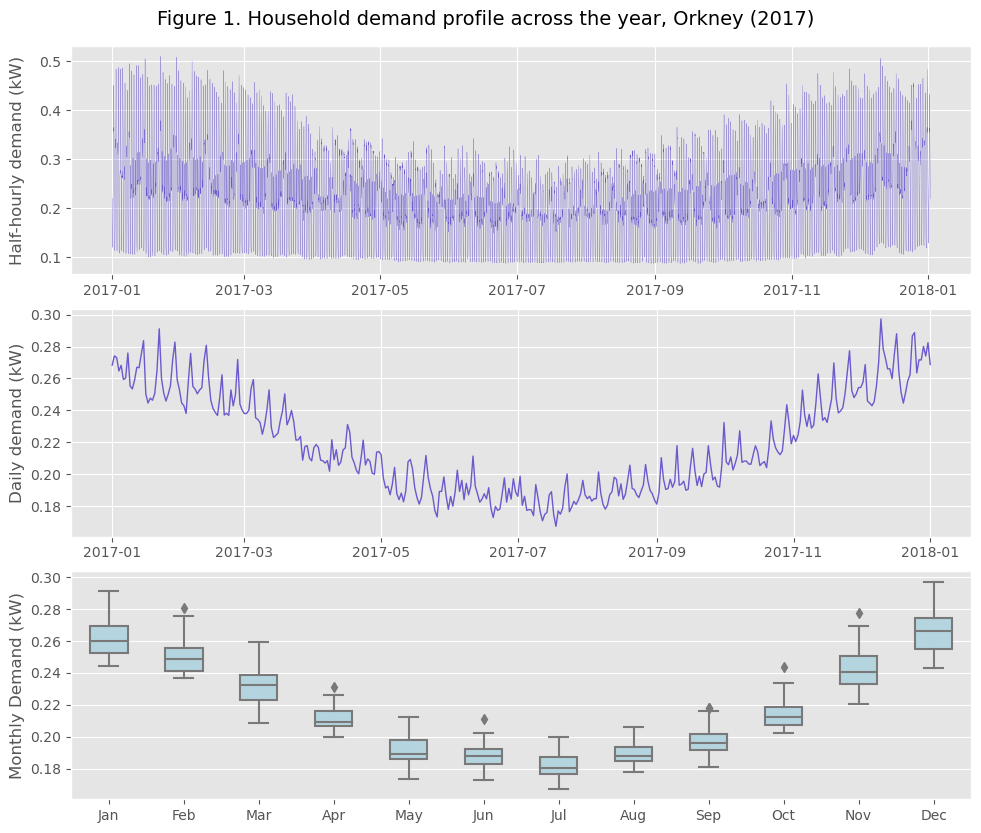

In [4]:
fig, axes = plt.subplots(nrows=3, figsize=(10,9))

sns.lineplot(data=demand_df #.groupby(by="date", as_index=False).agg('mean')
             , x='Timestamp', y='Demand_mean_kw'
             , color="slateblue", linewidth=0.2, ax=axes[0])
#axes[0] = demand_df.groupby(by="date").agg('mean')['Demand_mean_kw'].plot(color=color1, lw=1)
axes[0].set_ylabel("Half-hourly demand (kW)")
axes[0].set_xlabel(None)

sns.lineplot(data=demand_df.groupby(by="date", as_index=False).agg('mean')
             , x='date', y='Demand_mean_kw'
             , color="slateblue", linewidth=1, ax=axes[1])
axes[1].set_ylabel("Daily demand (kW)")
axes[1].set_xlabel(None)

sns.boxplot(data=demand_df.groupby(by=['date', 'day_of_week', 'month_of_year'], as_index=False).agg('mean')
            , x='month_of_year', y='Demand_mean_kw'
            , color='lightblue', width=0.5, ax=axes[2])
axes[2].set_ylabel("Monthly Demand (kW)")
axes[2].set_xlabel("Month")
axes[2].set_xticklabels(calendar.month_abbr[1:13])
axes[2].set_xlabel(None)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.align_ylabels(axes)
fig.suptitle("Figure 1. Household demand profile across the year, Orkney (2017)"
             , fontsize=14, y=0.92)

plt.show()

We can also check the energy demand profile within the day as shown in figure below. From the plot, we can further draw the following household demand patterns and behaviours: 

* The demand pattern shows two peaks in demand, one in the morning and one in the evening; this indicates the level of activity in the household where the first peak is when residents wake up and the sceond peak is when residents return from work
  * The first peak demand occurs at an earlier timing during the weekdays than the weekends, likely due to the residents waking up early to work whereas they could start their day later in the weekends
  * The first peak demand is also higher during the weekends than the weekdays, likely because residents tend to stay at home and consume more electricity in the weekends
  * The second peak demand is approximately the same level across the week, the same with the level of off-peak demand
* The patterns in electricity consumption is the same throughout the months, with some months having higher level likely during winter where more energy is demanded for heating 

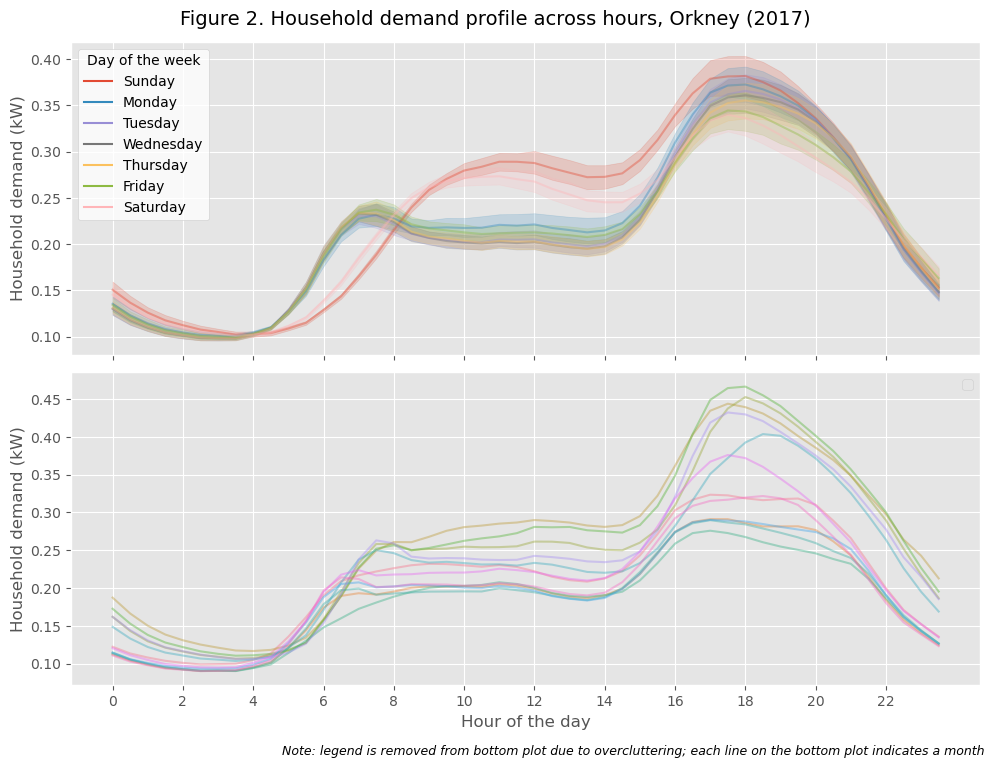

In [5]:
# Plot half-hourly demand by different days and months
fig, axes = plt.subplots(nrows=2, figsize=(10,8), sharex=True)
                         
sns.lineplot(data=demand_df
             , x='time_of_day', y='Demand_mean_kw'
             , hue='day_of_week', alpha=0.4, ax=axes[0])
axes[0].legend(title="Day of the week", facecolor="white")
axes[0].set_ylabel("Household demand (kW)")

sns.lineplot(data=demand_df.groupby(by=['month_abbr', 'time_of_day'], as_index=False).agg('mean')
             , x='time_of_day', y='Demand_mean_kw'
             , hue='month_abbr', alpha=0.4, ax=axes[1])
axes[1].legend([])
axes[1].set_ylabel("Household demand (kW)")

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.align_ylabels(axes)
fig.suptitle("Figure 2. Household demand profile across hours, Orkney (2017)"
             , fontsize=14, y=0.92)
fig.text(0.99, 0.001, "Note: legend is removed from bottom plot due to overcluttering; " \
                       + "each line on the bottom plot indicates a month"
         , fontstyle="oblique", fontsize=9
         , horizontalalignment="right", verticalalignment="top")

plt.xlabel("Hour of the day")
plt.xticks(np.arange(0, 24, 2))
plt.show()

Energy is obtained by taking the area under the power curve, which we can simply calculate by multiplying power and time interval. Doing so, we obtain the energy consumption level per household in Orkney, 2017 as shown below and in figure below. The daily consumption level tops at around 7 kWh and bottoms at around 4 kWh.

We notice that this energy (electricity) consumption level is relatively low compared to a typical household in the UK [$^{[3][4]}$](#ref_2), which is estimated to be 2,900 kWh annually and at least 8 kWh in a day. We can surmise that either (i) the dataset is **not as representative of the population** or potentially, (ii) a percentage of the households **resort to other energy sources especially for heating** such as coal or oil burners instead of electric heating.

In [6]:
# Get energy demanded across the year (area under power demand curve) and average daily demand
demand_df['Energy_demand_kwh'] = demand_df['Demand_mean_kw'] * 0.5
annual_demand = demand_df['Energy_demand_kwh'].sum()
daily_demand = demand_df.groupby(by='date').sum()['Energy_demand_kwh'].mean()
total_demand = annual_demand * 10385 # total across all households
print("\033[1m\033[4mHousehold energy consumption in Orkney (2017)\033[0m")
print(f"Average annual energy consumption\t: {annual_demand:>10,.2f} kWh")
print(f"Average daily energy consumption\t: {daily_demand:>10,.2f} kWh")

Household energy consumption in Orkney (2017)
Average annual energy consumption	:   1,924.49 kWh
Average daily energy consumption	:       5.26 kWh


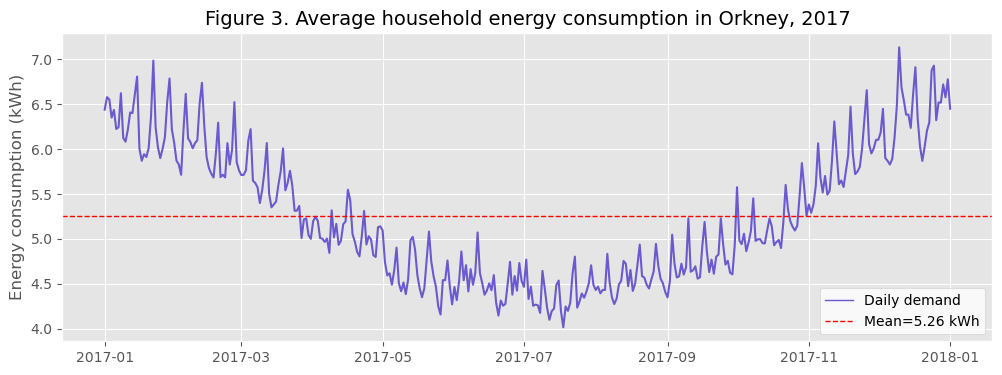

In [7]:
plt.figure(figsize=(12,4))
sns.lineplot(data=demand_df.groupby(by='date', as_index=False).agg('sum')
             , x='date', y='Energy_demand_kwh', color="slateblue")
plt.axhline(y=daily_demand, linestyle='--', linewidth=1, color="red")
linepatch1 = Line2D([0], [0], color="slateblue", linewidth=1, linestyle='-')
linepatch2 = Line2D([0], [0], color="red", linewidth=1, linestyle='--')
plt.xlabel(None)
plt.ylabel("Energy consumption (kWh)")
plt.title("Figure 3. Average household energy consumption in Orkney, 2017", fontsize=14)
plt.legend([linepatch1, linepatch2], ['Daily demand', 'Mean=5.26 kWh'], loc="lower right", facecolor="white")
plt.show()

From the above findings, we can calculate our total annual domestic energy (electricity) consumption across all households in Orkney in 2017 to be:

$$
\begin{aligned}
\widehat{\text{Consumed}}_{household}
        &= 10,385 \text{ households } \times 1,924.49 \text{ kWh } \\
        &\approx 19.986 \text{ GWh}
\end{aligned}
$$

This total also can be roughly approximated by using the mean power demand, as we have established that the main bulk of the demand is approximately stable. To calculate using this method, we have:

$$
\begin{aligned}
\widehat{\text{Consumed}}_{household}
        &= 10,385 \text{ households } \times 0.22 \text{ kWh } \times 365 \text{ days } \times 24 \text{ h / day }\\
        &\approx 20.014 \text{ GWh } (\approxeq 19.986 \text{ GWh})
\end{aligned}
$$


*Note that this result is far below the official statistics of 81.8 GWh, which may require further investigation. Nevertheless, we will use this result for subsequent calculations.*

After estimating the household consumption, we have to also consider the energy consumed by the industrial and commercial sector to get the total consumption. We know from official statistics that industrial consumption totals to 56.3 GWh. Therefore we have the overall annual estimated energy consumption to be:

$$
\begin{aligned}
\widehat{\text{Consumed}}
        &= 19.986 \text{ GWh } + 56.3 \text{ GWh } \\
        &\approx 76.286 \text{ GWh}
\end{aligned}
$$

<br><br>
<a style='float:left;' href="#section_3">Back to [ III. Understanding Curtailment in Orkney ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="section_2_2"></a>

### 2. Potential Wind Turbine Energy Generation

Next, we proceed to estimate the maximum potential that the wind turbine farm in Orkney can generate. To do so, we need to know two things: 
(i) the number of turbines operating in Orkney, and 
(ii) the power generated by a given wind speed.

Based on the available information online, we find that Orkney hosts over 500 domestic scale (900kW) wind turbines[$^{[5]}$](#ref_2) and so subsequently we will assume that there are 500 turbines in operation.

Assuming that these turbines operates at full-scale capacity for the whole year, we can calculate the upper limit of the annual potential energy to be: 

$$
\begin{aligned}
\text{Potential}_{upper} 
        &= 500 \text{ turbines } \times 365 \text{ days } \times 24 \text{ h/day } \times 900 \text{ kW } \\
        &\approx 3,942 \text{ GWh}
\end{aligned}
$$

To properly estimate the potential energy, we will look into the telemetry data recorded in one of the wind turbine. A brief summary statistics of the telemetry data can be seen in table below, where:

* Average wind speed to be roughly 10 m/s with standard deviation 5.5 m/s
* Average power generated across the year is approximately 367 kW, but we observe a high standard deviation of 340 indicating how uncertain wind energy generation can be

In [8]:
# Brief overview of the Demand dataframe and the summary statistics
print("\033[1m\033[4mTable 2. Summary statistics of turbine telemetry data\033[0m")
with pd.option_context('float_format', '{:,.2f}'.format):
    display(turbine_df.describe().T)

Table 2. Summary statistics of turbine telemetry data


,count,mean,std,min,25%,50%,75%,max
Power_kw,"1,066,934.00",367.19,339.96,0.00,51.00,251.00,704.00,938.00
Setpoint_kw,"1,066,921.00",810.66,261.51,0.00,900.00,900.00,900.00,900.00
Wind_ms,"1,066,931.00",9.96,5.45,0.00,6.10,9.00,12.40,47.20


In [9]:
# Extract datetime information from `Timestamp` column
turbine_df['date'] = turbine_df['Timestamp'].dt.date
turbine_df['year'] = turbine_df['Timestamp'].dt.year
turbine_df['month_of_year'] = turbine_df['Timestamp'].dt.month
turbine_df['day_of_week'] = turbine_df['Timestamp'].dt.day_name()
turbine_df['time_of_day'] = turbine_df['Timestamp'].dt.hour + turbine_df['Timestamp'].dt.minute / 60
turbine_df['timestamp_diff'] = turbine_df['Timestamp'].diff().shift(-1)

In [10]:
# Slice dataframe that contain information on power generation based on wind speed
generate_df = turbine_df[(turbine_df['Power_kw'] > 0) & (turbine_df['Setpoint_kw'] == 900)
                         & (turbine_df['Wind_ms'] > 0) & (turbine_df['Wind_ms'] <= 20)].copy()

Next, to estimate the power generated by any given wind speed, we visualise the relationship between power and wind speed through scatter plots as shown in figure below.

To ensure that we observe the right relationship between power and wind, we filter the data based on the following conditions:

* Power generated is greater than 0
* Turbine set point is maxed at 900 kW
* Wind speed is between 0 and 20 m/s

As we plot the filtered data points, we find a high proportion of noise in the data as seen in the LHS plot. To circumvent this cluttering of data, we tune our parameter `alpha=0.01` to fade out the infrequent observations on the RHS plot. From the figure, we observe that the power generated increases at an increasing rate with wind speed up to around 13 to 14 m/s where the power generated is capped at 900 kW.

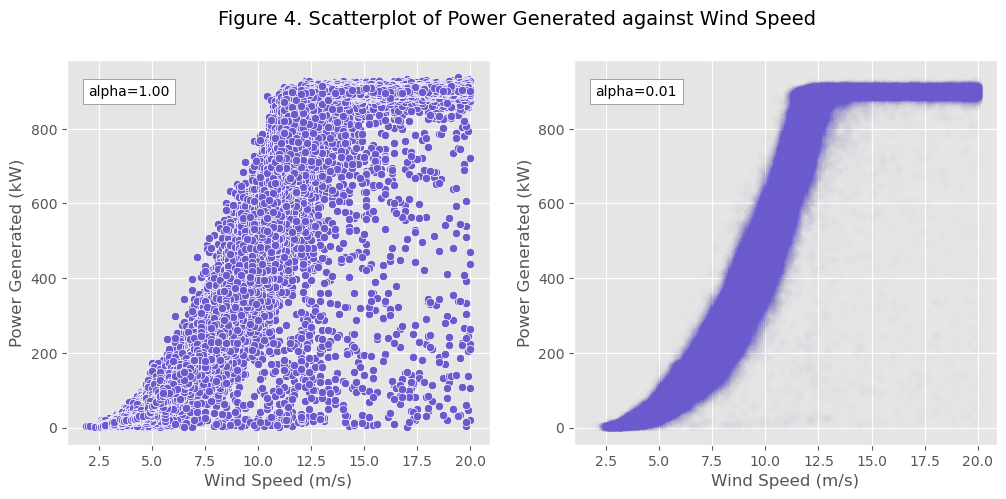

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(data=generate_df, x="Wind_ms", y="Power_kw", color="slateblue", ax=axes[0])
axes[0].text(2, 900, "alpha=1.00", ha="left", va="center"
             , bbox={'facecolor':'white', 'edgecolor':'grey'})
axes[0].set_xlabel("Wind Speed (m/s)")
axes[0].set_ylabel("Power Generated (kW)")

sns.scatterplot(data=generate_df, x="Wind_ms", y="Power_kw", color="slateblue", ax=axes[1], alpha=0.01)
axes[1].text(2, 900, "alpha=0.01", ha="left", va="center"
             , bbox={'facecolor':'white', 'edgecolor':'grey'})
axes[1].set_xlabel("Wind Speed (m/s)")
axes[1].set_ylabel("Power Generated (kW)")

plt.suptitle("Figure 4. Scatterplot of Power Generated against Wind Speed", fontsize=14)
plt.show()

In [12]:
# Create function to capture quantiles at Q1 and Q3
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

# Create bin-intervals to capture varying levels of wind speed and the corresponding median power generated
bins = np.arange(2, 15.5, 0.5)
generate_df['bins'] = pd.cut(generate_df['Wind_ms'], bins=bins)

# Store power-wind mapping
power_df = generate_df[['bins', 'Power_kw']].groupby('bins').agg(['mean', 'median', q1, q3])

In [13]:
# Store in dictionary for future mapping and custom plot
left_bound_power = {'mean':{}, 'median':{}, 'q1':{}, 'q3':{}}
for row in power_df.itertuples():
    left_bound_power['mean'][row[0].left] = row[1]
    left_bound_power['median'][row[0].left] = row[2]
    left_bound_power['q1'][row[0].left] = row[3]
    left_bound_power['q3'][row[0].left] = row[4]

Using these observations, we model the power generated from various levels of wind speed as shown in figure below. We find that this model to be the most representative. ([appendix 3](#appendix_3))

The model estimates power generation based on key statistics at any given wind level. We assume that a wind speed of at least 2 m/s is required to crank the wind turbine and generate power. Any wind speed beyond 15 m/s is assumed to generate maximum power of 900 kW. We will use this model to estimate the potential power, hence energy, generated in Orkney.

*Note: too low of a wind speed will not have enough force to rotate the turbine, and lower threshold of 2 m/s is based on minimum wind speed that generates power which we found to be 1.9 m/s*

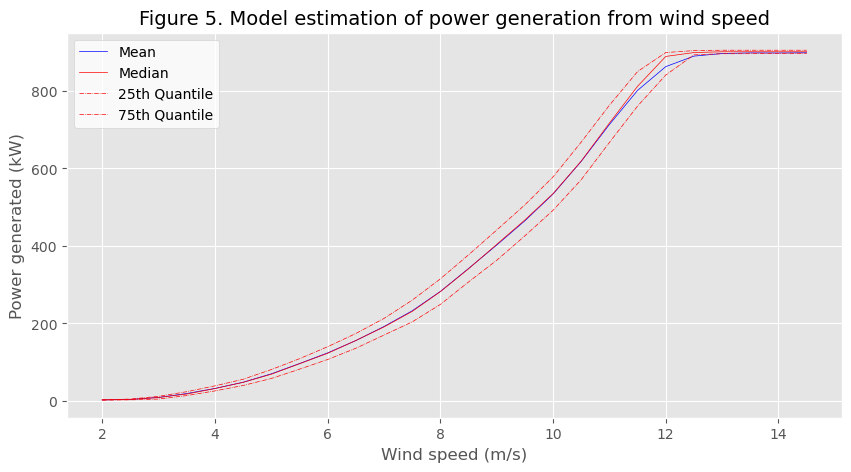

In [14]:
plt.figure(figsize=(10,5))

plt.plot(left_bound_power['mean'].keys(), left_bound_power['mean'].values(), lw=0.5, color="blue")
plt.plot(left_bound_power['median'].keys(), left_bound_power['median'].values(), lw=0.5, color="red")
plt.plot(left_bound_power['q1'].keys(), left_bound_power['q1'].values(), lw=0.5, ls="-.", color="red")
plt.plot(left_bound_power['q3'].keys(), left_bound_power['q3'].values(), lw=0.5, ls="-.", color="red")

plt.legend(['Mean', 'Median', '25th Quantile', '75th Quantile'], facecolor='white')
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power generated (kW)")
plt.title("Figure 5. Model estimation of power generation from wind speed", fontsize=14)
plt.show()

In [15]:
# Function to approximate potential power generated from wind speed
def approx_power(wind_speed, mapping, lower=2, upper=15):
    # Returns power generated from wind speed based on given mapping (linear search)
    if wind_speed < lower:
        return 0
    elif wind_speed > upper:
        return 900
    else:
        for k, v in mapping.items():
            if wind_speed in k:
                return v
            else:
                pass
    return 0

# Create windspeed-to-power mapping
power_map = (power_df['Power_kw']['mean'].to_dict())

# Estimate potential power generated by the wind turbine 
turbine_df['is_curtailed'] = turbine_df['Setpoint_kw'].apply(lambda x: 1 if x == 0 else 0)
turbine_df['mean_kw'] = turbine_df['Wind_ms'].apply(lambda x: approx_power(x, power_map))
turbine_df['potential_kw'] = turbine_df.apply(lambda row: row['mean_kw'] if row['is_curtailed'] == 1 
                                                          else row['Power_kw']
                                              , axis = 1)

After mapping the wind speed in the telemetry to the potential power generated, we can then calculate the potential energy generated from the power multiplied by time interval.

We need to note that, although 99.2% of the telemetry data are recorded in the 1-minute intervals, there are cases where the time interval is lower or higher than 1 minute. In particular, there is a **missing telemetry data in the period  between 3rd April 2017 to 24 April 2017**, which may arise either due to: (i) **dirty data**, (ii) **error in the transmission of telemetry** to the database or (iii) that the wind turbine is **malfunctioned** during this period. Hence, in the missing 21 days data, we will impute it with the 2017 annual wind speed average of **10.31 m/s**. ([appendix 4](#appendix_4))

Therefore, taking all these into account, we estimate the annual potential energy generated from a single typical turbine below:

In [16]:
# Calculate the energy generated by multiplying power and time interval (seconds convert to hours)
turbine_df['Energy_kwh'] = turbine_df['potential_kw'] * turbine_df['timestamp_diff'].apply(lambda x: x.total_seconds()) / 3600

# Slice the dataframe to before 3rd Apr and after 24 Apr
potential_df1 = turbine_df[(turbine_df['year'] == 2017) & (turbine_df['date'] <= pd.to_datetime('2017-04-02').date())]
potential_df2 = turbine_df[(turbine_df['year'] == 2017) & (turbine_df['date'] >= pd.to_datetime('2017-04-24').date())]

# Calculate the potential energy in the two time periods
potential_energy1 = potential_df1['Energy_kwh'].sum()
potential_energy2 = potential_df2['Energy_kwh'].sum()

# Calculate potential energy from missing 21 days data using average wind speed
annual_wind_mean = turbine_df[turbine_df['year'] == 2017].groupby('date').mean()['Wind_ms'].mean()
potential_energy3 = 21 * 24 *approx_power(annual_wind_mean, power_map) # 21 days, 24h/day

In [17]:
total_potential = (potential_energy1 + potential_energy2 + potential_energy3)

print("\033[1m\033[4mPotential energy breakdown (annual, single typical turbine)\033[0m")
print("Potential energy before 3rd April 2017\t\t: {:>8,.3f} GWh".format(potential_energy1 / 1_000_000))
print("Potential energy from 24th April 2017 onwards\t: {:8,.3f} GWh".format(potential_energy2 / 1_000_000))
print("Potential energy from imputed 21 days data\t: {:>8,.3f} GWh".format(potential_energy3 / 1_000_000))
print("\033[1m\nTotal annual estimated potential energy in 2017\t: {:>8,.3f} GWh\033[0m".format(total_potential/1_000_000))

Potential energy breakdown (annual, single typical turbine)
Potential energy before 3rd April 2017		:    1.136 GWh
Potential energy from 24th April 2017 onwards	:    2.566 GWh
Potential energy from imputed 21 days data	:    0.269 GWh

Total annual estimated potential energy in 2017	:    3.971 GWh


Lastly, we assume that the wind profile across Orkney is similar to a certain extent, especially since Orkney's area is relatively small at 990 square km. To account for this and potential variance in the wind profile across Orkney, we will use an adjustment multiplier, $\gamma=80\%$.

Therefore, the estimated annual potential energy generated in Orkney:

$$
\begin{aligned}
\widehat{\text{Potential }}
        &= \gamma \times 500 \text{ turbines } \times  3.971 \text{ GWh / turbines} \\
        &\approx 1,588.22 \text{ GWh}
\end{aligned}
$$

<br><br>
<a style='float:left;' href="#section_3">Back to [ III. Understanding Curtailment in Orkney ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="section_2_3"></a>

### 3. Estimated Annual Curtailment

We have obtained the potential energy and the consumption from the previous calculations. We then calculate the exported energy to the UK mainland from Orkney. We assume that the exported amount is at full transmission capacity, i.e. at 40MW, giving us the amount as follows:

$$
\begin{aligned}
\text{Exported}_{max}
        &= 40 \text{ MWh } \times 365 \text{ days } \times 24 \text{ h / day}\\
        &= 350.4 \text{ GWh}  
\end{aligned}
$$

Using the three estimations, we can then calculate the amount of annual energy curtailment from the wind turbine. We slightly modify the calculation on the curtailment by including a loss factor, $\lambda = 8\%$ to account for any energy lost during transmission[$^{[6]}$](#ref_2) to and from the grid or turbines.

Ultimately, we have our estimated annual curtailment to be:

$$
\begin{aligned}
\therefore \widehat{\text{Curtailed}}
        &= \widehat{\text{Potential}} - \frac{1}{1-\lambda} \left(  \widehat{\text{Consumed}} + \text{Exported}_{max} \right) \\
        &= 1,588.22 \text{ GWh } - \frac{76.286 + 350.4}{0.92} \text{ GWh} \\
        &\approx 1,124.44 \text{ GWh } \hspace{0.2cm} (70.8\%)
\end{aligned}
$$

<br><br>
<a style='float:left;' href="#section_3">Back to [ III. Understanding Curtailment in Orkney ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="section_4"></a>

## IV. Demand Response Evaluation

In this section, we evaluate the effectiveness of our DR schemes. To do so, we will approach it as follows:

* Calculate the potential energy consumption that can be increased through storage heaters and hot water cylinder;
* Assess the curtailment reduction across different levels of DR penetration from the estimated potential consumption;
* Estimate the implementation cost and compare it with the effectiveness

<a id="section_3_1"></a>

### 1. Energy Consumption through Heating

There are two main heating appliances that we target in the DR scheme, storage heaters and hot water cylinders. To estimate the energy consumption from these two appliances per household, we calculate the maximum potential consumption of each individual appliances.

#### A. Storage Heaters (Space)

To estimate the energy consumed by storage heaters we make the following assumptions:

* The power rating of a typical storage heater is 2 kW [$^{[7]}$](#ref_3)
* The number of rooms, hence the number of storage heaters, in a typical 2-person household space is roughly 4 rooms [$^{[8]}$](#ref_3)
* Heating is only required out of summer period, hence storage heaters used for a total of 8 months in a year [$^{[9]}$](#ref_3)
* The energy required to charge storage heater to full load is 9 hours, regardless of weekdays or weekends [$^{[9]}$](#ref_3)

Therefore, the energy demand from storage heaters in a household is estimated to be as follows:

$$
\begin{aligned}
\tilde{E}_{space} 
        &= 4 \times 2 \text{ kW } \times \frac{8}{12} \times 365 \text{ days } \times 9 \text{ h / day } \\
        &\approx 17.52 \text{ MWh (annual overall)} \\
        &\approxeq 48.0\text{ kWh (daily average)}
\end{aligned}
$$

#### B. Hot Water Cylinder (Water)

Similarly, we estimate the energy consumed by hot water cylinders by making the following assumptions:

* The power rating of a typical hot water cylinder is 3 kW [$^{[10][11]}$](#ref_3)
* The volume of hot water utilised in a 2-person household is approximately 50 liters  [$^{[12]}$](#ref_3)
* Water is heated from 15$^\circ$ to 75$^\circ$ with average power efficiency of 80%, hence requiring approximately 1.46 hours in a day
* Every other time of the day, it maintains the temperature at an average rate of 0.2 kW
* Heating power efficiency, mainly due to heat loss, at 80%


$$
\begin{aligned}
\tilde{E}_{water} 
        &= ( 1.46 \text{ h / day } \times 3 \text{ kW } ) + (  22.54 \text{ h / day } \times 0.2 \text{ kW } \div 80\% ) \\
        &\approx 10.015 \text{ kWh (daily average)} \\
        &\approxeq 3.655 \text{ MWh (annual overall)}
\end{aligned}
$$

#### Maximum consumption

Based on the energy demand for the two heating components calculated above, the total estimated energy that Orkney households can consume from heating in 2017 is:

$$
\begin{aligned}
\tilde{E}_{heating} 
        &= 10,385 \text{ household } \times (\tilde{E}_{space} + \tilde{E}_{water}) \\
        &= 10,385 \text{ household } \times (17.52 \text{ MWh } + 3.655 \text{ MWh}) \\
        &\approx 219.902 \text{ GWh (annual)}
\end{aligned}
$$

By substracting this amount with the current consumption, we can also figure out the amount of energy consumption that we can target using the DR scheme. Furthermore, assuming that a typical household in UK uses 90% of their energy consumption for heating[$^{[13]}$](#ref_4) *(and consequently, we assume that the increased consumption in heating induce an increase in other electricity consumption, hence maintaining the same proportion of total consumption)*, we can then estimate the maximum potential increase in household energy demand to be:

$$
\begin{aligned}
\tilde{E}_{DR} 
        &= 219.902 \text{ GWh } \div 90\% \\
        &\approx 244.336 \text{ GWh (annual)}
\end{aligned}
$$

Therefore, if we re-estimate the new energy consumption across Orkney, including the industrial and commercial sectors, we have the following:

$$
\begin{aligned}
\widehat{\text{Consumed}}_{new}
        &= \tilde{E}_{DR} + E_{industrial} \\
        &= 244.336 \text{ GWh } + 56.3 \text{ GWh } \\
        &\approx 300.636 \text{ GWh (annual)}
\end{aligned}
$$


<br><br>
<a style='float:left;' href="#section_4">Back to [ IV. Demand Response Evaluation ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="section_3_2"></a>

### 2. Curtailment Reduction

Now that we have estimated the potential energy used for household heating, we can calculate the overall maximum energy consumption in Orkney as well as the maximum reduction in curtailment.

Assuming 8% power loss during transmission, we calculate the new level of curtailment based on the maximum potential consumption level:

$$
\begin{aligned}
\therefore \widehat{\text{Curtailed}_{DR_{max}}}
        &= \widehat{\text{Potential}} - \frac{1}{1-\lambda} \left(  \widehat{\text{Consumed}}_{new} + \text{Exported}_{max} \right) \\
        &= 1,588.22 \text{ GWh } - \frac{300.636 + 350.4}{0.92} \text{ GWh} \\
        &\approx 880.572 \text{ GWh } \hspace{0.2cm} (55.4\%)
\end{aligned}
$$


Based on our estimate of the ideal scenario, we can see a **15.4\% reduction in curtailment when all household adopts the DR scheme.**

This assumption, however, may not hold true, depending on the level of penetration of the DR schemes. It is especially true when we conduct further investigation on the electricity usage across the Orkney demography. 

As of 2017, we find that only 41\% of Orkney households use electric heating[$^{[14]}$](#ref_4), while the remaining 59% use other alternatives such as oil or solid fuels like coal. This may restrict the penetration rate of our DR scheme, as we need to have the other household segment to install electrical heating appliances and encourage their uses which may be very costly for this segment.

To account for this variability, we build an Excel model to estimate the reduction in curtailment across various DR penetration ([appendix 6](#appendix_6)). In the model, we assume that our DR scheme targets the residents with electricity use for heating first before targetting the ones with alternative fuel sources. 

Our estimation at various DR penetration is shown below.

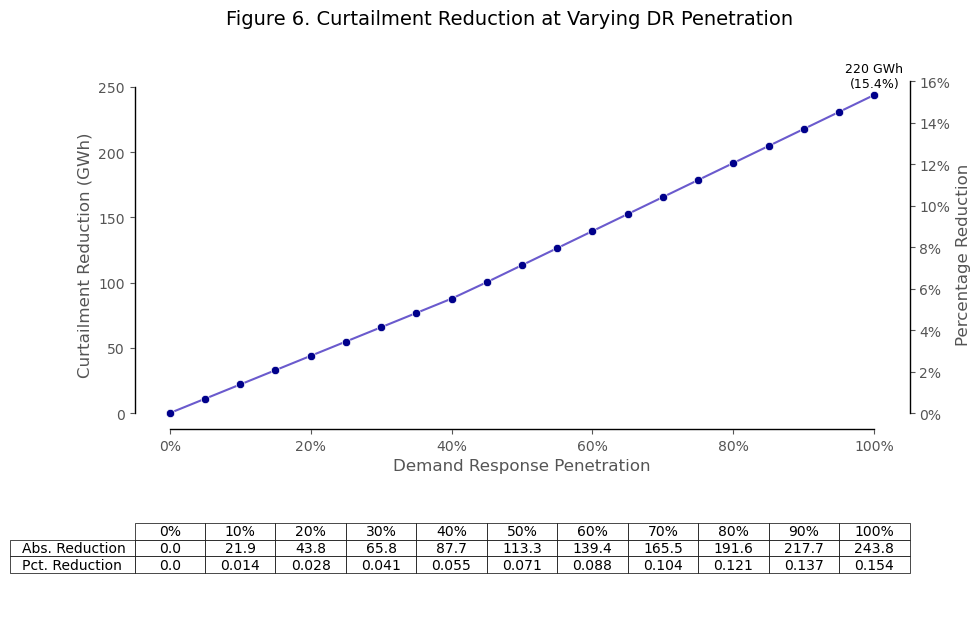

In [18]:
#reductions = [0, 9.769084981, 19.63556997, 29.50205497, 39.36853996, 49.23502495
#              , 59.10150994, 68.96799494, 78.83447993, 90.24947679, 102.0516016
#              , 113.8537264, 125.6558513, 137.4579761, 149.2601009, 161.0622257
#              , 172.8643506, 184.6664754, 196.4686002, 208.270725, 220.0728499]

reductions = [0, 10.95915409, 21.91830819, 32.87746228, 43.83661637, 54.79577046
              , 65.75492456, 76.71407865, 87.67323274, 100.3022278, 113.3486832
              , 126.3951385, 139.4415938, 152.4880492, 165.5345045, 178.5809598
              , 191.6274152, 204.6738705, 217.7203258, 230.7667812, 243.8132365]

denom = (0.8 * 500 * total_potential / 1_000_000)
pct_reduced = reductions / denom
dr_levels = np.round(np.linspace(0,1,21),2)

dr_df = pd.DataFrame(data={'DR Penetration': dr_levels, 
                           'Abs. Reduction': np.round(np.array(reductions),1), 
                           'Pct. Reduction': np.round(np.array(pct_reduced),3)})

fig, axes = plt.subplots(nrows=2, figsize=(10,7), gridspec_kw={'height_ratios': [5, 2]})
color1, color2 = "slateblue", "darkblue"
ax1 = axes[0]

sns.lineplot(x=dr_levels, y=reductions, ax=ax1, color=color1)
ax1.set_ylabel("Curtailment Reduction (GWh)")
ax1.set_xlabel("Demand Response Penetration")
ax1.set_xticks(np.linspace(0,1,6)
               , labels=["0%", "20%", "40%", "60%", "80%", "100%"])
ax1.grid(visible=False, axis="y")
ax1.set_facecolor("white")

ax2 = ax1.twinx()
sns.scatterplot(x=dr_levels, y=pct_reduced, ax=ax2, color=color2)
ax2.text(1,0.156, "220 GWh\n(15.4%)", ha="center", va="bottom", fontsize=9)
ax2.set_ylabel("Percentage Reduction")
ax2.set_yticks(np.arange(0,0.17,0.02)
               , labels=["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%", "16%"])
ax2.grid(visible=False, axis="y")

ax2.spines['left'].set_color("black")
ax2.spines['left'].set_bounds(0, 250 / denom)

ax2.spines['right'].set_color("black")
ax2.spines['right'].set_bounds(0, 0.16)

ax2.spines['bottom'].set_color("black")
ax2.spines['bottom'].set_bounds(0, 1)

table_df = dr_df.iloc[np.arange(0,21,2),:]
table_header = ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"]
axes[1].table(cellText=table_df.iloc[:,1:3].values.T, colLabels=table_header,
              rowLabels=table_df.columns[1:3], cellLoc="center", loc="center")
axes[1].axis('off')
axes[1].axis('tight')

plt.suptitle("Figure 6. Curtailment Reduction at Varying DR Penetration", fontsize=14)
plt.show()

Although in the ideal scenario we achieve a 15.4% reduction in curtailment, our findings and model may suggest that it is difficult to attain that level of reduction. 

**Assuming that all Orkney residents who uses electricity for heating fully adopts our DR strategy, we have 41% DR penetration rate, i.e. about 4,442 households, which brings curtailment down by approximately 89.865 GWh (5.7\%).**

To further push forward with our DR schemes to target the resident segment with non-electric heating, we have to further evaluate the implementation cost if it is reasonable.

<br><br>
<a style='float:left;' href="#section_4">Back to [ IV. Demand Response Evaluation ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="section_3_3"></a>

### 3. Implementation Cost

We can now estimate the value of our DR schemes and compare it against the implementation costs for cost-benefit assessment. There are several cases that we need to consider in terms of the implementation cost:

#### A. Variable Cost from Reimbursing DR Energy Consumption for Kaluza

Firstly, we consider that we achived 100% DR penetration rate, with the aim of reducing as much curtailment as possible. To estimate the cost we make the following assumptions below:

* All residents have the Kaluza controlled appliances installed
* The energy consumed for heating is approximately 48 kWh for storage heater and 10.015 kWh for hot water cylinder
* The provider, Kaluza, covers only the cost borne from heating consumption
* Off-peak hours are between 10pm to 7am and 11am to 5pm, totals to 16 hours
* Storage heaters consume energy only during off-peak time, bearing off-peak tariffs
* Hot water cylinders consume energy during peak hours for 8 hours
* Electricity tariffs is 17 pence, and the off-peak tariffs is assumed to be reduced by 50%

$$
\begin{aligned}
\widehat{\text{Cost}}_{Kaluza} 
        &= \text{Cost}_{SH} + \text{Cost}_{HW} \\
        &= 0.17 \big[ ( 48 \times 50\%) +  ( 10.015 \times \frac{8}{24}) +  ( 10.015 \times \frac{16}{24} \times 50\%) \big] \\
        &\approx £ 5.215 \text{ per household / day}
\end{aligned}
$$

<br>

Therefore, if all household adopts the technology (100% DR penetration), the variable cost borne by us would be **£54,158.12 per day**.

**However, if we assume that 59% of the residents do not have the infrastructure for DR technology to be installed**, i.e. storage heaters and hot water cylinder available due to reliance on alternative fuels, then our **penetration rate would be 41% with a cost of £22,204.83 per day**.

#### B. One-time Charge for Enrolling in DR Scheme for Households

To implement the DR technology, the household needs device-compatible heating appliances, which will incur a certain cost to either the household consumers or us as the DR-device provider. In our business case, **we will pass this cost to the household and turn it into a revenue source for us.**

As we have established, Orkney households are segmented into those that uses electric heating (segment 1) and those that uses alternative fuel sources for heating (segment 2). We differentiate the cost for these two segments, where segment 1 has an existing electric heating appliances while segment 2 do not yet have electric heating appliances. Hence, there are two prices that we charge to households: (i) the quote for new heating appliances, including distribution and installation, and (ii) the quote for our smart device installation. Assuming that the smart device needs to be installed in each appliance, we can break down the quotation in the two segment to be:

| Segment | Appliance Type | New Appliance | Smart Device | Quantity | Total Price | 
| --- | --- | --- | --- | --- | --- |
| 1 | Storage Heater | - | £100 | 4 | £400 |
| 1 | Hot Water Cylinder | - | £100 | 1 | £100 |
| 2 | Storage Heater | £600 | £100 | 4 | £2,800 |
| 2 | Hot Water Cylinder | £300 | £100 | 1 | £400 |

Taking the above into account, we can calculate for the cost incurred per household segment to be:

* Segment 1 - £500
* Segment 2 - £3,200

Assuming that all household participates, the total costs borne by the household will be:

$$
\begin{aligned}
\widehat{\text{Cost}}_{household}
        &= (41\% \times 10,385 \times £500) + (59\% \times 10,385 \times £3,200) \\
        &= £ 21,735,805 \\
        &\approx £ 21.736 \text{ M }
\end{aligned}
$$

However, the cost of new installations for segment 2 is very high, more than double segment 1. It is unlikely that this household segment would participate in the DR schemes without enough incentives.


#### C. Profit from DR Device Installation for Kaluza

For each device installation, we would take a margin as our profit. To estimate our profit, we assume the following:

* There is a 20% profit margin from the device installation alone
* The supply of new appliances are charged at true cost, i.e. we are not taking any profit from supplying new heating appliances

Hence, we can simply calculate our profit per household to be $£500 \times 20\% = £100$.

Assuming all household opt to install the devive, we will receive an immediate profit of £1,038,500 from the installations. However, if we assume that households from segment 2 do not join, the profit would be approximately £425,784 from installations alone.

#### D.Breakeven Period for Kaluza

Assuming that we use the 20% profit margin we get from the device installation to cover for the fully-subsidised tariffs, we have the following:

$$
\begin{aligned}
\widehat{\text{Installation Profit}} &= \widehat{\text{Cost}}_{Kaluza} \\
£100 \text{ per household } &= £5.215 \text{ per household / day} \\
\therefore \text{Breakeven Period } &= \frac{£100}{£5.215} \\
 &\approx 19.2 \text{ days}
\end{aligned}
$$

Therefore, from our perspective, as long as the subsidised period is below 19.2 days, we will be making profit while expanding our customer base. We could set our trial period to be 30 days and our profit will therefore be:

$$
\begin{aligned}
\widehat{\text{Profit}} 
        &= £ 100 \text{ per household } - 30 \text{ days } \times £5.215 \text{ per household / day} \\
        &= -£56.45  \text{ per household (i.e. a net loss) }
\end{aligned}
$$

We will dive deeper into various potential scenarios across different DR penetration levels and subsidised period in later section following the same calculations and principles shown above.

#### E. Incentives for Households

Households are practically getting free electricity for a specified period. However, electricity costs of subsequent periods would need to be borne by the individual households themselves. We can take the perspective of the households to assess the cost-benefit and valuate the DR scheme.

Assuming that the DR schemes only run for 30 days and that we only managed to target segment 1 of the household, the net value that the segment 1 household borne by enrolling in the DR scheme is $30 \text{days} \times £5.215 - £500 = -£343.55$, i.e. a loss more than £300. Therefore, for this scheme to be worthwhile, there must be some further incentives in the long-run such as a discounted electricity tariff when using DR-controlled devices.

This value can be estimated as follows:

$$
\text{Net Cost} = \text{Period} \times \text{Discount on Tariffs}
$$

In the case above, for example, we have a net cost of £343.55 that the segment 1 household bears. Suppose we offer a 30% discount for future tariffs. This means that the houshold would be able to "breakeven" in $\frac{£343.55}{0.3 \times £5.215 \text{ per day}}=219.6 \text{ days}$, i.e. their initial net loss would have been covered by the discount in the next 220 days, while benefiting from the discount from day 221 onwards. Households who values this proposition should be willing to join in the DR schemes offered.

#### F. Long-run Sustainability for Kaluza and Energy Providers

To find a sustainable solution in the long-run where we will not be burdened by the full subsidy provided to the residents, we may consider charging the residents at a discount.

One potential approach would be to collaborate with the wind energy provider and bear the discount on the tariffs for households together. In order to retain, or even attract, the residents adopting the DR technology, we need to ensure that the energy tariffs for the DR usage be equal to or less than the previous fees before implementing DR. This aligns with our consideration towards household incentives in the previous section.

We consider the following assumptions:

* Electricity fee for DR scheme is £ 5.215 per day per household
* Households receive a discount on the electricity fee for heating
* Kaluza and the energy provider bear certain percentages of the tariffs
* Energy provider received 90% profit rate on the fees charged to the households 
* Kaluza takes some percentage, of the profit received by the energy provider from the electricity fees

If we denote the proportion of discount provided to the households by Kaluza and the energy provider as $d_k$ and $d_e$ respectively, and the commission rate charged to energy provider as $c$, we can calculate the fair value of the discount-to-commission rate as:

$$
\begin{aligned}
Revenue &= Cost \\
90\% \times 5.215 \times (1-d_k-d_e) \times c &=  5.215 \times d_k \\
c &= \frac{d_k}{0.9 \times (1-d_k-d_e)}
\end{aligned}
$$

Therefore, whatever commission we are charging the wind energy provider has to be at least greater than or equal to $\frac{d_k}{0.9 \times (1-d_k-d_e)}$. For example, if both the energy provider and us provide a 15% discount each, we need to charge at least $0.15 / 0.9 \times (1-0.15-0.15) = 0.2381$ i.e. minimum 23.81% of the profit that the provider received from the electricity fees. To the wind energy provider, their opportunity cost to this is curtailed energy i.e. £0, hence we should be able to negotiate for a higher commission rate and the energy provider should be willing to accept.


<br><br>
<a style='float:left;' href="#section_4">Back to [ IV. Demand Response Evaluation ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="section_5"></a>

## V. Business Plan

Based on our findings, we formulate a business plan to enter Orkney market as the smart device provider. To obtain a comprehensive view of the DR scheme and develop a business plan for entering the Orkney market, we have taken into account both the pre-DR and post-DR situations for all parties involved, namely the residents, the energy provider and ourselves. Additionally, we conduct a range of scenario analysis to estimate the profit earned by Kaluza with the implementation of the DR scheme.


*Note: we may refer to households using electrical heating appliances as electricity users or segment 1, interchangeably; the households without electrical heating are referred to as other users or segment 2, again interchangeably.*

### A. Residents

#### Before DR

We first simulated the situation before implementing the DR scheme by making the following assumptions:

* The energy consumption per hour by electricity users is 11.26 kWh, while other users consume 1.13 kWh.
*  average electricity tariff is determined as the weighted arithmetic mean of the peak-time and off-peak hour prices, resulting in a value of 14 pence

Based on these assumptions, we can calculate the total average electricity fee per day for all residents. Additionally, we can determine the electricity fees specifically for electricity users (segment 1) and other users (segment 2).

$$
\begin{aligned}
\widehat{\text{Electricity Fee}}_{before} 
        &= £0.14 \text{ per day} \times \sum (\text{energy consumed } \times \text{ proportion of user}) \\
        &= £0.14 \times (41\% \times 11.26 \text{ kWh} + 59\% \times 1.13 \text{ kWh}) \\
        &\approx £0.748 \text{ per day}
\end{aligned}
$$

We can also split by segment proportion and have the fees for each segment as follows:

* Electricity users: £1.59 per day
* Electricity users: £0.16 per day

#### After DR

Similarly, to estimate the electricity fee after the implementation of DR, following assumptions are considered:

* The energy consumed for heating is approximately 48 kWh for storage heater and 10.015 kWh for hot water cylinder
* Heating amounts for approximately 90% of the overall electricity consumption
* Both electricity users and other users are provided same amount of electricity
* The total discount provided to the households by Kaluza and the energy provider is 50%
* The storage heater only consumes electricity during off-peak hours

Using our Excel model that we built, we have the final fees as follows:

| Storage Heater | Hot Water Cylinder | $\sum$ Electricity Fee $_{after}$ |
| --- | --- | --- |
| £2.04 | £0.93 | £2.97 |

### B. Energy provider

#### Before DR

As mentioned earlier, considering that the energy provider receives a 90% profit rate on the fees charged to households, we can calculate the total profit received by the energy provider per day.

$$
\begin{aligned}
\widehat{\text{Profit}}_{before} 
        &= 10,385 \text{ households } \times 90\% \times \widehat{\text{Electricity Fee}}_{before} \\
        &\approx £6,991.18
\end{aligned}
$$

#### After DR

To estimate the total profit per day generated by the DR scheme, we have adopted the assumption that electricity users who are inclined to participate in DR will do so initially, followed by other users joining subsequently. By altering the DR levels, we can evaluate the profitability under various circumstances. Again, using our Excel model to estimate the new profits from the new demand we have the following:

**Table 3. Energy Provider's New Profit with Demand Response (DR) Scheme**

![Excel Model on Provider's Profit](DR_excel_provider_profit.png)

### Kaluza

#### During DR

To realistically simulate of the scenario during the DR scheme, we have made several assumptions:

* Kaluza managed to secure government subsidy of £1,000,000 towards the DR scheme
* Kaluza spent £10,000 for marketing and promotion on local channels
* In order to assess the impact on profits, the company has the flexibility to adjust the duration of the free heating subsidy

In the project, Kaluza will be subject to the variable cost from subsidising the electricity tariffs, but earns some profit from the smart device installation. Adding the above assumptions, we then perform scenario analysis on several free-heating durations and across the different DR levels. Based on our excel model, we have the following:

**Table 4. Kaluza's Profit with Demand Response (DR) Scheme**

![Excel Model on Kaluza's Profit](DR_excel_kaluza_profit.png)

We can also visualise the profit and loss (P&L) generated in the figure below.

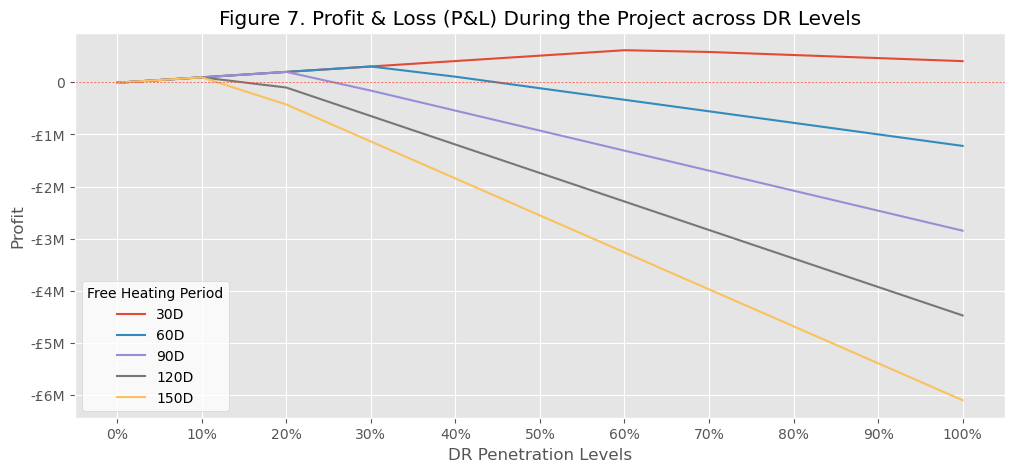

In [19]:
# Hard-coded profit from Excel model
project_profit = {
    "Levels": ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"],
    "30D": [-10_000, 93_850, 197_700, 301_550, 405_400, 509_250, 613_100, 579_742.74, 521_134.56, 462_526.38, 403_918.20],
    "60D": [-10_000, 93_850, 197_700, 301_550, 105_734.56, -115_331.80, -336_398.16, -557_464.52, -778_530.88, -999_597.24, -1_220_663.60],
    "90D": [-10_000, 93_850, 197_700, -160_573.62, -544_098.16, -927_622.70, -1_311_147.24, -1_694_671.78, -2_078_196.33, -2_461_720.87, -2_845_245.41],
    "120D": [-10_000, 93_850, -101_965.44, -647_948.16, -1_193_930.88, -1_739_913.60, -2_285_896.33, -2_831_879.05, -3_377_861.77, -3_923_844.49, -4_469_827.21],
    "150D": [-10_000, 93_850, -426_881.80, -1_135_322.70, -1_843_763.60, -2_552_204.51, -3_260_645.41, -3_969_086.31, -4_677_527.21, -5_385_968.11, -6_094_409.01]
}

profit_df = pd.DataFrame(project_profit)
profit_long_df = profit_df.melt(id_vars="Levels", var_name="Length", value_name="Profit")
profit_long_df["Scaled"] = profit_long_df["Profit"] / 1_000_000

plt.figure(figsize=(12,5))
sns.lineplot(data=profit_long_df, x="Levels", y="Scaled", hue="Length")
plt.axhline(y=0, lw=0.5, ls="--")
plt.legend(facecolor="white", title="Free Heating Period")
plt.gca().set_yticks(np.arange(-6,1,1)
                    , labels=["-£6M", "-£5M", "-£4M", "-£3M", "-£2M", "-£1M", "0"])
plt.xlabel("DR Penetration Levels")
plt.ylabel("Profit")
plt.title("Figure 7. Profit & Loss (P&L) During the Project across DR Levels")
plt.show()

#### After DR

Suppose Kaluza and the energy provider have reached an agreement on a 50% commission rate following the implementation of the DR scheme. We can calculate the profit for Kaluza from the profit generated by the DR

$$
\begin{aligned}
\widehat{\text{Profit per day}}_{Kaluza} 
        &= (\text{Profit}_{after} - \text{Profit}_{before}) \times \text{Commission %} \\
        &\approx £9,081.09 \text{ per day}
\end{aligned}
$$

In this manner, we can also calculate the breakeven time for Kaluza using the following equation:

$$
\begin{aligned}
\widehat{\text{Breakeven}}_{Kaluza} 
        &= - \widehat{\text{Profit}}_{Kaluza} \div \widehat{\text{Profit per day}}_{Kaluza}
\end{aligned}
$$

Based on this, we further perform scenario analysis on the breakeven periods on several free-heating durations and across the different DR levels in Excel. Based on our model we have the following:

**Table 5. Period (in days) for Kaluza to Breakven from Demand Response (DR) Scheme**

![Excel Model on Kaluza's Breakeven Period](DR_excel_kaluza_breakeven.png)

We can also visualise the breakeven period required to cover for any net loss in the figure| below.

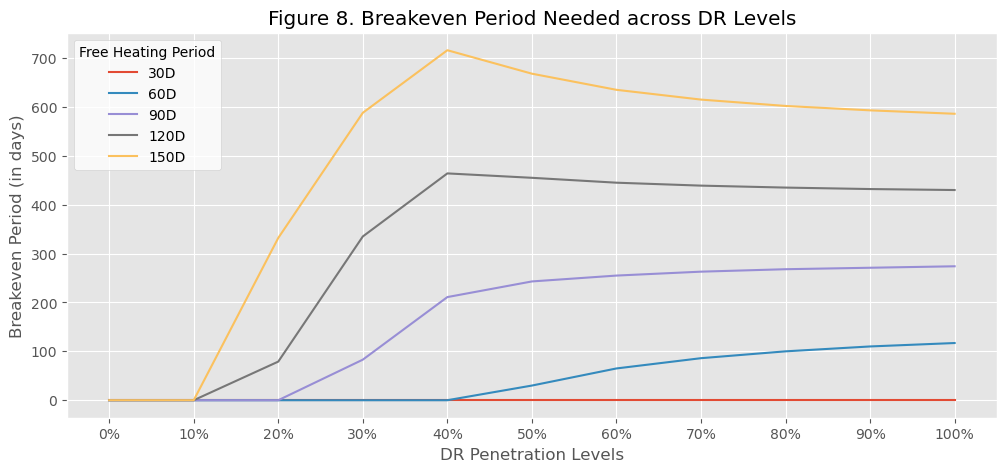

In [20]:
# Hard-coded breakeven period from Excel model
breakeven_period = {
    "Levels": ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"],
    "30D": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "60D": [0, 0, 0, 0, 0, 30, 65, 86, 100, 110, 117],
    "90D": [0, 0, 0, 83, 211, 243, 255, 263, 268, 271, 274],
    "120D": [0,0, 79, 335, 464, 455, 445, 439, 435, 432, 430],
    "150D": [0,0, 332, 588, 716, 668, 635, 615, 602, 593, 586],
}

be_df = pd.DataFrame(breakeven_period)
be_long_df = be_df.melt(id_vars="Levels", var_name="Length", value_name="Period")

plt.figure(figsize=(12,5))
sns.lineplot(data=be_long_df, x="Levels", y="Period", hue="Length")
plt.legend(facecolor="white", title="Free Heating Period")
plt.xlabel("DR Penetration Levels")
plt.ylabel("Breakeven Period (in days)")
plt.title("Figure 8. Breakeven Period Needed across DR Levels")
plt.show()

### Final Recommendation

Considering the substantial financial investment made in promoting this project, it is anticipated that under optimistic circumstances, 90% of the total households would participate in the DR scheme. Therefore, Kaluza should select a duration length that aligns with a 90% DR level. In this case, we propose that a 90-day duration would be a suitable option for several reasons.

Firstly, by opting for a 90% DR level and a 90-day duration, we can calculate that the breakeven period amounts to 271 days. This duration falls within a one-year timeframe, making it feasible and acceptable in terms of minimizing losses for the company during the trial period. Consequently, the company's exposure to significant liquidity risk is mitigated. Secondly, a 90-day duration encompasses an entire season, making it a time interval that can be more easily implemented. This allows for better alignment with seasonal energy consumption patterns and facilitates effective evaluation of the DR scheme's impact.

Taking these factors into account, selecting a 90-day duration appears to strike a balance between financial viability, risk management, and practical implementation considerations for Kaluza. We summarise our proposed business plan details below:

| Detail | Amount |
| --- | --- |
| Target DR level | 90% |
| Free heating period | 90 days |
| Government Subsidy | + £1 M |
| Marketing Cost | - £10 K |
| Net profit | - £ 2.46 M |
| Breakeven period | 271 days |


While this calculation may appear passive in excluding the device's own profitability, it employs the safest method currently available. However, if additional profit rates or information about the equipment itself are provided, we can offer a more optimistic assessment.


<br><br>
<a style='float:left;' href="#section_5">Back to [ V. Business Plan ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="section_6"></a>

## VI. Potential Alternatives

### A. Alternative storage 

Instead of consuming the energy immediately, we could propose to store the energy in alternative forms such as battery grid or hydrogen storage. The main challenge for this is the capital expenditures and land space constraint. 

### B. New transmission cables

Although it was mentioned that installing new transmission cables for more export is expensive, it could generate returns in the long run. Several factors to consider when considering this are:

* The distance between Orkney and Scottish mainland
* The seawater depth between the Orkney island and the mainland
* Cable capacity requirements and installation

By considering these costs and finding the breakeven period, we may justify the business case for new transmission cables.

<br><br>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="section_7"></a>

## VII. Conclusion


Based on our research, data explorations and modelling, we find that there is a potential to implement DR scheme in Orkney given the high estimated curtailment size of 1,124.44 GWh (70.8%). The amount of curtailment that we can potentially reduce is approximately 15.4%. We further note that there are two segments of households in Orkney, one that uses electrical heating at 41% and the other that uses alternative fuel at 59%, which induce cost differences. 

In our business plan to enter this market, we aim for a DR penetration rate of 90%, while providing free electricity to the households for approximately 90 days. From our estimate, this would incur a net cost £2.4M with breakeven period of 271 days, in which after 271 days we can potentially make profit of £9.1K per day.



<br><br>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="appendices"></a>

## VIII. Appendices

<a id="appendix_1"></a>

### Appendix 1. Basic Descriptive Statistics

#### 1.1. Summary Statistics

Here, we get a high-level overview of our dataset. 

**Demand Dataset:**

* We observe a max power demand of 0.51 kW and min of 0.09 kW, with mean of 22 kW
* The mean power demand is found to be 0.22 kW
* Standard deviation of the demand is relatively high at 0.09 kW
* Max number of household is suspiciously high at 30,037

**Turbine Telemetry Dataset:**

* We observe a max power generated at 938 kW, which is slightly higher than the upper setpont threshold of 900 kW per turbine
* Maximum wind speed is at 47.2 m/s and 0 m/s at the minimum with average-to-date being 9.96 m/s
* This particular turbine sample seems to be rarely curtailed as the setpoint is mostly at 900 kW even at the 25-th percentile

In [21]:
demand_df[["Demand_mean_kw", "N_households"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Demand_mean_kw,17568.0,0.219090,0.090129,0.086607,0.143592,0.212315,0.273678,0.509662
N_households,17568.0,8630.642133,2999.141750,5406.000000,6781.000000,8190.500000,9652.000000,30037.000000


In [22]:
turbine_df[["Power_kw", "Setpoint_kw", "Wind_ms"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Power_kw,1066934.0,367.187058,339.963650,0.0,51.0,251.0,704.0,938.0
Setpoint_kw,1066921.0,810.657814,261.507116,0.0,900.0,900.0,900.0,900.0
Wind_ms,1066931.0,9.955093,5.453944,0.0,6.1,9.0,12.4,47.2


#### 1.2. Distribution of Data

**Household Mean Demand:**

* Mean demand has two peaks in its distribution, at around 0.1 kW and 0.2 kW, followed by a fat right-tail distribution
* This first peak represent the period of low electricity usage, showing slightly higher frequency than the second peak, while The fat tail shows period of high electricity usage

**Wind Speed:**

* Wind speed in Orkney displays long-tail distribution, which makes sense as there will be rare occurances, but not impossible, of extreme wind
* The wind speed that occurs at the highest frequency is at the range between 8 m/s to 11 m/s

**Power Generation:**

* Power generated from the sample turbine shows two extremes, one at 0 kW and another at 900 kW
* No power generated, i.e. 0 kW seems to occur very frequently which could either be the result of no wind or curtailment
* Otherwise, power are also generated across the range from 0 kW to 900 kW due to differing wind speed

**Setpoint:**

* It appears that for the sample turbine, most of the time, the setpoint is set to 900 kW i.e. not curtailed
* There are a small proportion of curtailment indicated by 0 kW setpoint

In [23]:
# Function to plot distribution of selected column in a dataframe
def plot_distribution(df, x, title):
    fig, ax1 = plt.subplots(figsize=(10,5))
    sns.histplot(data=df, x=x, ax=ax1)

    ax2 = ax1.twinx()
    sns.kdeplot(data=df, x=x, ax=ax2)
    ax2.grid(visible=False, axis="y")

    plt.title(title)
    plt.show()

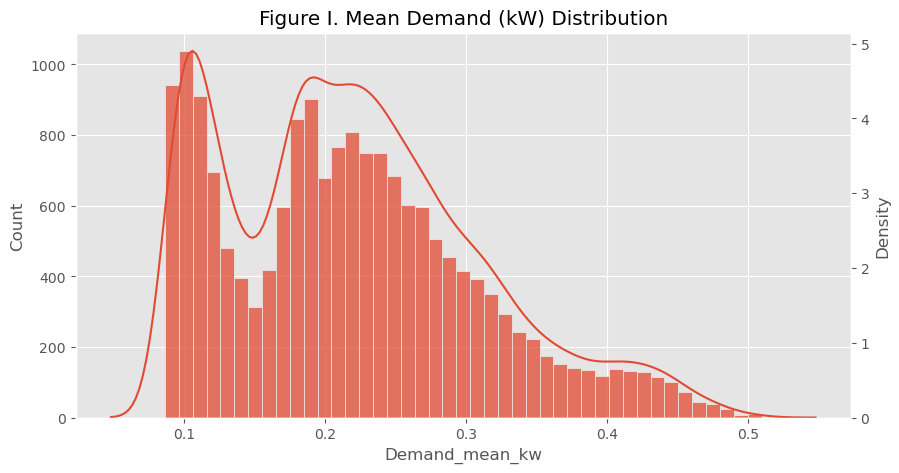

In [24]:
plot_distribution(demand_df, "Demand_mean_kw", "Figure I. Mean Demand (kW) Distribution")

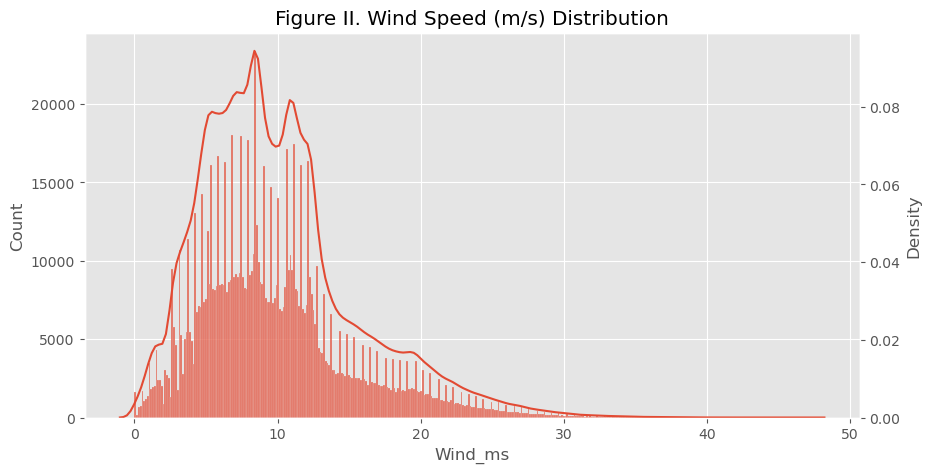

In [25]:
plot_distribution(turbine_df, "Wind_ms", "Figure II. Wind Speed (m/s) Distribution")

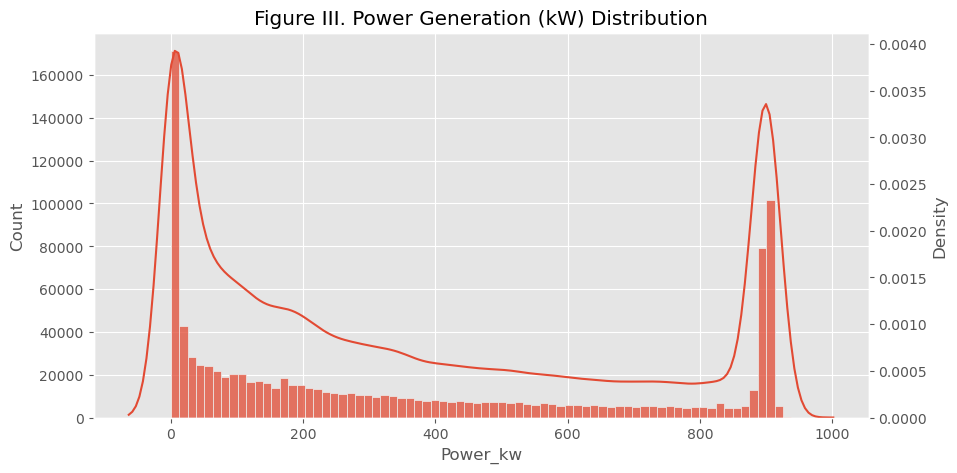

In [26]:
plot_distribution(turbine_df, "Power_kw", "Figure III. Power Generation (kW) Distribution")

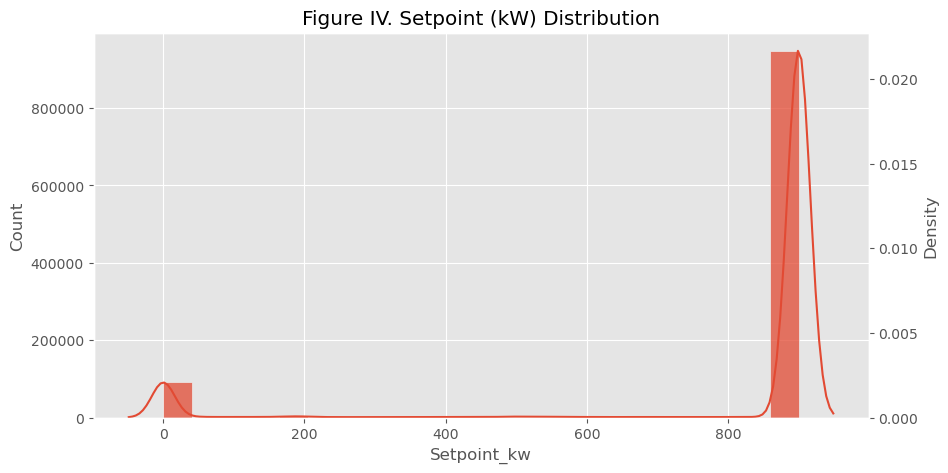

In [27]:
plot_distribution(turbine_df, "Setpoint_kw", "Figure IV. Setpoint (kW) Distribution")

<a id="appendix_2"></a>

### Appendix 2. Orkney's demographic household

Number of households recorded in the dataset provided by Kaluza exceed the official record from the office of statistics. One reason might be due to duplicated "household IDs" being aggregated by Kaluza during data preparation. We can observe this anomaly during the month of September and December as seen in the figure below.

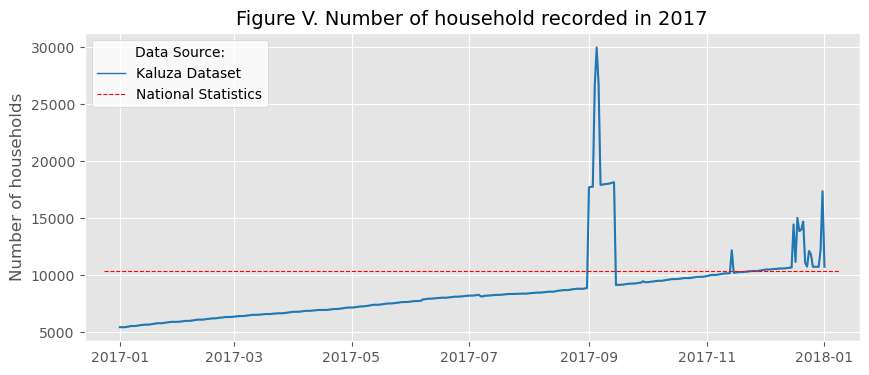

In [28]:
plt.figure(figsize=(10,4))
ax = sns.lineplot(data=demand_df, x="date", y="N_households", color=default_color)
ax.axhline(y=10_385, xmin=0.025, xmax=0.975, color="red", ls="--", lw=0.8)

linepatch1 = Line2D([0], [0], color=default_color, linewidth=1, linestyle='-')
linepatch2 = Line2D([0], [0], color="red", linewidth=0.8, linestyle='--')

plt.xlabel(None)
plt.ylabel("Number of households")
plt.title("Figure V. Number of household recorded in 2017", fontsize=14)
plt.legend([linepatch1, linepatch2], ['Kaluza Dataset', 'National Statistics'], loc="upper left", facecolor="white", title="Data Source:")
plt.show()

<a id="appendix_3"></a>

### Appendix 3. Modelling power from wind explorations

We tested regression model to estimate the power generated from various levels of wind speed. However, we find that this method does not display a good fit as per the relationship observed in the scatter plot between power and wind. We then plot heatmaps to provide an alternative visualisation of the distribution and relationship between power and wind. From these explorations we surmise that the method to best model the relationship is by using simple statistics such as mean and the quantiles in different wind speed classes (or ranges).

#### 3.1. Scatter Plot of Power against Wind Speed

We can visualise the relation between power and wind speed by, firstly, plotting the scatter plots. We tune the parameter `alpha=0.05` which enables us to filter out the noise and better visualise the data. From the figure, we can observe that there is a convex parabolic relationship between power and wind speed. There is a upper threshold of 900 kW due to the turbine setpoint capacity, which limits the power generated to 900 kW regardless of wind speed. Anny wind speed beyond 15 m/s seems to generate maximum power at 900 kW.

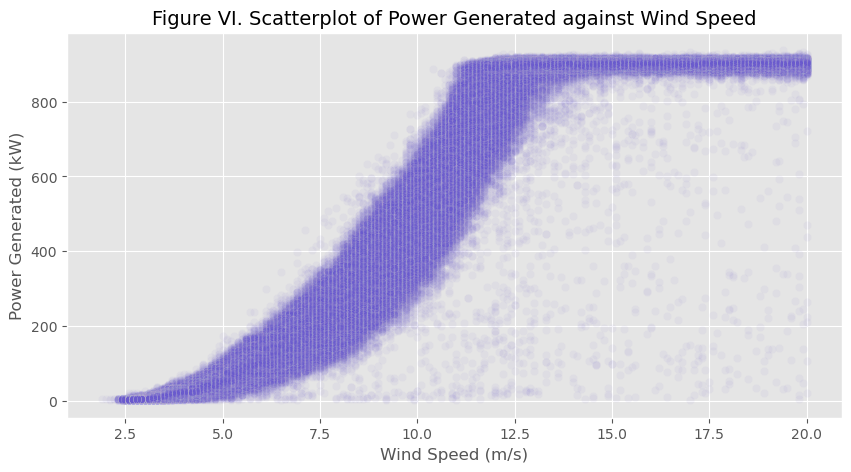

In [29]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=generate_df, x="Wind_ms", y="Power_kw", color="slateblue",alpha=0.05)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Generated (kW)")
plt.title("Figure VI. Scatterplot of Power Generated against Wind Speed", fontsize=14)
plt.show()

#### 3.2. Modelling power-wind relationship using regression

As we can see, the relationship displayed using regression fails to accurately capture the power generated when wind is at relatively low speed of 5 m/s and below as weel as when wind is relatively close to 15 m/s or beyond. At low speed, the regression would return negative power, which we will consider to be no power generated. However at high speed, the power generated increases at a decreasing rate (with quadratic form) which is opposite of what we observe in the scatterplot pattern (increase at increasing rate). Hence, we will abandon the regression approach to estimating the power generated from wind speed.

In [30]:
from sklearn.linear_model import LinearRegression
model_df = generate_df.copy()
model_df['Wind_ms_sq'] = model_df['Wind_ms'] ** 2

In [31]:
# Fit OLS model with wind speed
X1 = model_df[['Wind_ms']]
y = model_df['Power_kw']
model1 = LinearRegression().fit(X1, y)

# Fit OLS model with wind speed and its degree-2 polynomial
X2 = model_df[['Wind_ms', 'Wind_ms_sq']]
y = model_df['Power_kw']
model2 = LinearRegression().fit(X2, y)

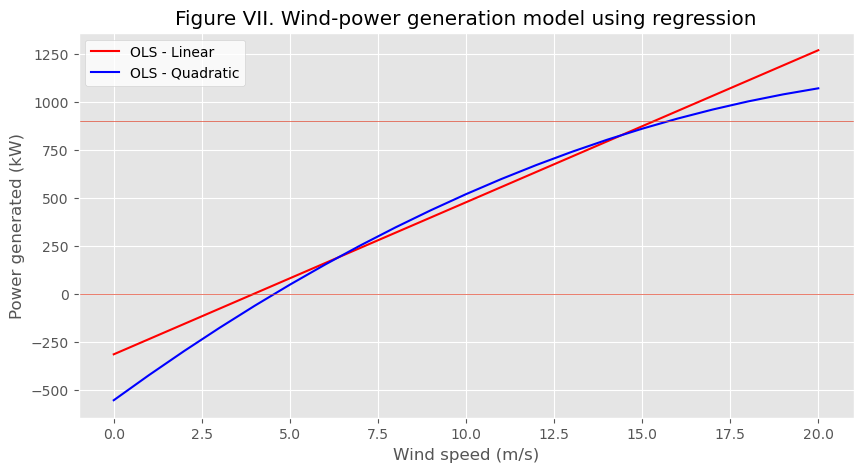

In [32]:
import warnings
warnings.filterwarnings('ignore')

wind_test1 = np.reshape(np.arange(0,21), (-1,1))
wind_test2 = np.column_stack((np.arange(0,21), np.arange(0,21)**2))
power_model1 = model1.predict(wind_test1)
power_model2 = model2.predict(wind_test2)

plt.figure(figsize=(10,5))
plt.plot(wind_test1, power_model1, color="red")
plt.plot(wind_test1, power_model2, color="blue")
plt.axhline(y=900, lw=0.5)
plt.axhline(y=0, lw=0.5)
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power generated (kW)")
plt.title("Figure VII. Wind-power generation model using regression")
plt.legend(["OLS - Linear", "OLS - Quadratic"], facecolor="white")
plt.show()

#### 3.3. Heatmap Visualisation

Using heatmap to visualise the distribution of the power and wind speed in 2 dimensions, we can observe a pattern of the power level generated at different wind speed levels (or bins). For example, we see that at 4 m/s and below, the power generated is between 0 and 100 kW, whereas at a wind speed between 6 and 8 m/s the power generated is most likely between 100 and 200 kW.

With this, we can conclude that simple statistical estimates would suffice to model the relationship between power and wind speed which we display in the main report on [Section 2.2](#section_2_2).

In [33]:
# Create bin-intervals to capture varying levels of wind speed and the corresponding median power generated
wind_bins = np.arange(0, 21, 2)
power_bins = np.arange(0, 1000, 100)
heatmap_df = generate_df.copy()
heatmap_df['wind_bins'] = pd.cut(heatmap_df['Wind_ms'], bins=wind_bins)
heatmap_df['power_bins'] = pd.cut(heatmap_df['Power_kw'], bins=power_bins)

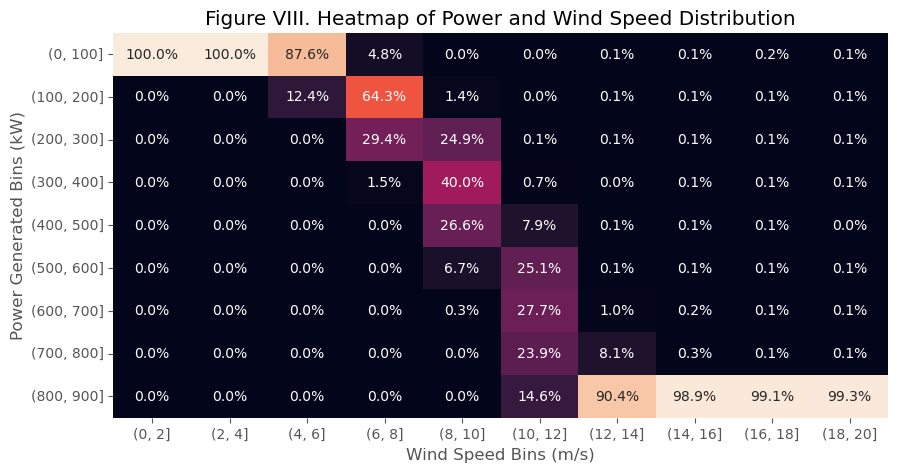

In [34]:
# Create heatmap by using pivot table on the dataframe
plt.figure(figsize=(10,5))
sns.heatmap(data=(heatmap_df.pivot_table(values="Power_kw", index="power_bins", columns="wind_bins", aggfunc="count")
                            .apply(lambda x: x/sum(x), axis=0))
            , annot=True
            , fmt=".1%"
            , cbar=False)
plt.title("Figure VIII. Heatmap of Power and Wind Speed Distribution")
plt.xlabel("Wind Speed Bins (m/s)")
plt.ylabel("Power Generated Bins (kW)")
plt.show()

<a id="appendix_4"></a>

### Appendix 4. Time interval between telemetric records

To calculate for the energy generated, we need to multiply the power generated by time interval in which the power is used. Since, it is highly sensitive to the time interval that we used, we need to ensure that the time interval used to calculate energy makes sense.

We observe a 21-day gap in the data in the month of April, with 99.2% of the data having time interval between 59s to 61s on average from the figure below and the summary statistics calculated after. We can use 1-min interval for majority of the data, and an average estimation of power generated for the 21-day gap.

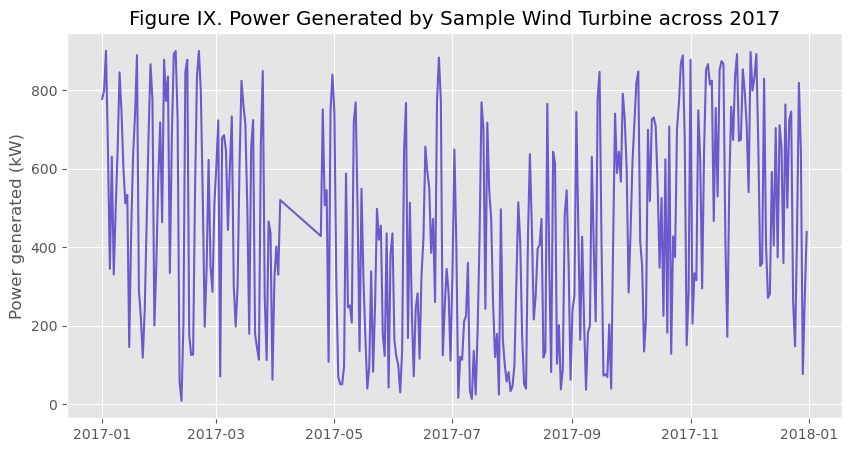

In [35]:
plt.figure(figsize=(10,5))
turbine_df[turbine_df['year'] == 2017].groupby('date').mean()['potential_kw'].plot(color="slateblue")
plt.xlabel(None)
plt.ylabel("Power generated (kW)")
plt.title("Figure IX. Power Generated by Sample Wind Turbine across 2017")
plt.show()

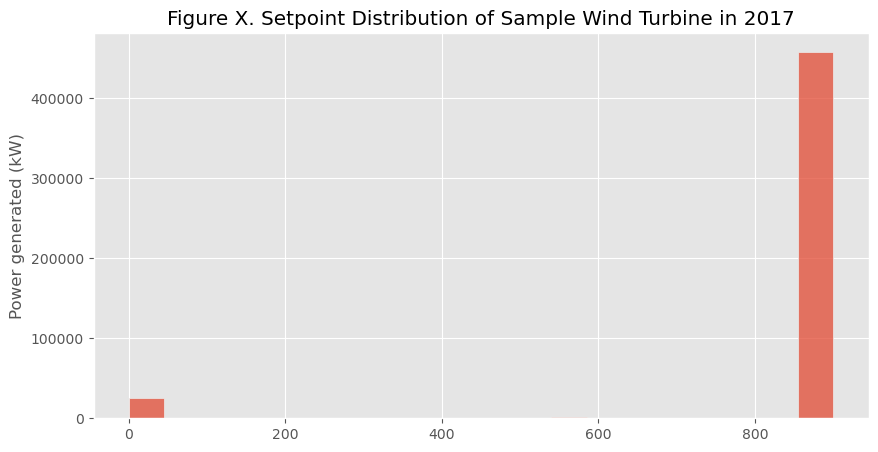

In [36]:
plt.figure(figsize=(10,5))
sns.histplot(turbine_df[turbine_df['year'] == 2017]['Setpoint_kw'])
plt.xlabel(None)
plt.ylabel("Power generated (kW)")
plt.title("Figure X. Setpoint Distribution of Sample Wind Turbine in 2017")
plt.show()

In [37]:
check_interval = turbine_df[turbine_df['year'] == 2017]['timestamp_diff'] #.apply(lambda x: x.total_seconds())
count_interval = check_interval.value_counts()
print("1% quantile\t\t:", check_interval.quantile(0.01))
print("99% quantile\t\t:", check_interval.quantile(0.99))
print("Extreme values (max)\t:", max(check_interval))
print("Extreme values (min)\t:", min(check_interval))
print("Top interval values\t:")
print((count_interval[:5] / sum(count_interval)))

1% quantile		: 0 days 00:00:59
99% quantile		: 0 days 00:01:00
Extreme values (max)	: 20 days 12:11:22
Extreme values (min)	: 0 days 00:00:01
Top interval values	:
0 days 00:01:00    0.981185
0 days 00:00:59    0.007379
0 days 00:01:01    0.003914
0 days 00:00:01    0.003580
0 days 00:00:04    0.001157
Name: timestamp_diff, dtype: float64


In [38]:
# estimate the mean of the wind speed to get the power for the 21-day gap
est_mean_windspeed = turbine_df[turbine_df['year'] == 2017].groupby('date').mean()['Wind_ms'].mean()
est_mean_power = approx_power(annual_wind_mean, power_map)
print("Estimated mean wind speed\t: {:>8.2f} m/s".format(est_mean_windspeed))
print("Estimated mean power generated\t: {:>8.2f} kW".format(est_mean_power))

Estimated mean wind speed	:    10.31 m/s
Estimated mean power generated	:   533.89 kW


<a id="appendix_5"></a>

### Appendix 5. Curtailment from given single wind turbine

If we perform EDA on the specific wind turbine provided, we can find the averaage energy generated by this wind turbine and the percentage of curtailment across the month. We find that the curtailment is the highest in the month of June to September, which is to be expected as there is little to no heating used during Summer, reaching up to 20% curtailment from a single turbine.

*We need to take note that this single turbine does not represent the actual curtailment across Orkney, as curtailment is done from the newest to the oldest turbine one-by-one*

In [39]:
# Plot % curtailed across the month
def plot_curtail_month(df, title):
    df['prop_curtail'] = df['curtail'] / (df['curtail'] + df['normal'])
    df['prop_normal'] = df['normal'] / (df['curtail'] + df['normal'])
    
    df.plot(y=["prop_curtail", "prop_normal"], figsize=(12,4)
            , kind="bar", stacked=True, color=["red", "lightblue"])

    for i, idx in enumerate(df.index.values):
        plt.text(x=i, y=df.loc[idx, "prop_curtail"] + 0.01
                 , s=f'{np.round(df.loc[idx, "prop_curtail"] * 100, 1)}%'
                 , color="black", horizontalalignment="center", size=8.5)

    plt.legend(['% Curtailed', '% Normal Op'])
    plt.xticks(rotation=0)
    plt.yticks(ticks=np.linspace(0,1,6), labels=["0", "20%", "40%", "60%", "80%", "100%"])
    plt.xlabel("Month of the year")
    plt.title(title)
    plt.show()

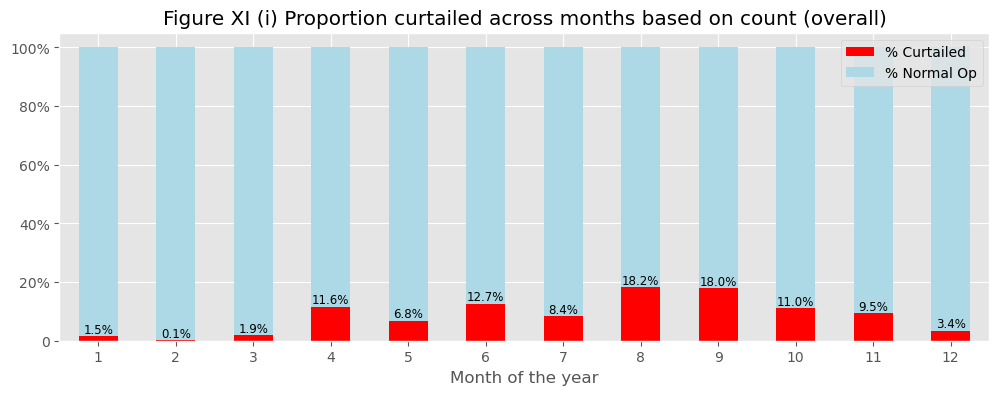

In [40]:
curtailed_df1 = (turbine_df.groupby(by=["month_of_year"])
                           .apply(lambda df: pd.Series({'curtail': (df["is_curtailed"] == 1).sum()
                                                        , 'normal': (df["is_curtailed"] == 0).sum()}))
                )
plot_curtail_month(curtailed_df1, "Figure XI (i) Proportion curtailed across months based on count (overall)")

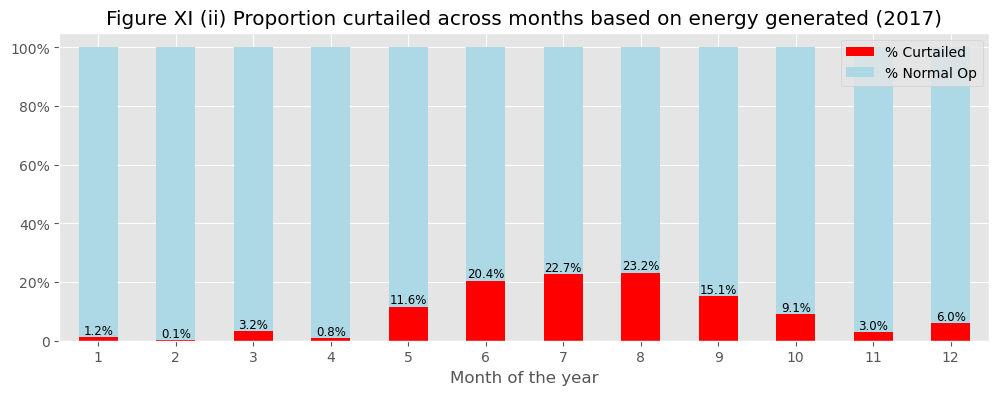

In [41]:
curtailed_df3 = (turbine_df[turbine_df['year'] == 2017]
                        .groupby(by=["month_of_year"])
                        .apply(lambda df: pd.Series({'curtail': df[df["is_curtailed"] == 1]['Energy_kwh'].sum()
                                                     , 'normal': df[df["is_curtailed"] == 0]['Energy_kwh'].sum()}))
                )
plot_curtail_month(curtailed_df3, "Figure XI (ii) Proportion curtailed across months based on energy generated (2017)")

<a id="appendix_6"></a>

### Appendix 6. Modelling Curtailment Reduction across DR Penetration

Calculating the curtailment reduction in our Excel model, we obtain the table below. *Note: Excel model will be attached separately.*

<img src="DR_excel_model.png" alt="Curtailment Reduction Across DR Penetration" />

<a style='float:left;' href="#appendices">Back to [ VIII. Appendices ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>

<a id="references"></a>

## IX. References

<a id="ref_1"></a>

### 1. Demographics & Energy Profile

[1] National Records of Scotland (2018). *Estimates of Households and Dwellings in Scotland, 2017.* Retreived from: https://webarchive.nrscotland.gov.uk/20210313060658/https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/households/household-estimates/2017

[2] Department for Business, Energy & Industrial Strategy (2019). *Statistical data set: Total final energy consumption at regional and local authority level 2005 to 2017.* Retreived from: https://www.gov.uk/government/statistical-data-sets/total-final-energy-consumption-at-regional-and-local-authority-level

<a id="ref_2"></a>

### 2. Wind Turbines Power Generation

[3] Topping, C. (2021) *Average electricity usage in the UK: how many kWh does your home use?* OVO Energy. Retreived from: https://www.ovoenergy.com/guides/energy-guides/how-much-electricity-does-a-home-use

[4] Ofgem (n.d.) *Average gas and electricity use explained.* Retreived from: https://www.ofgem.gov.uk/information-consumers/energy-advice-households/average-gas-and-electricity-use-explained

[5] Orkney Renewable Energy Forum (n.d.) *Wind.* Retreived from: https://www.oref.co.uk/orkneys-energy-1/wind/

[6] The World Bank (2018). *Electric power transmission and distribution losses (% of output) - United Kingdom.* Retreived from: https://data.worldbank.org/indicator/EG.ELC.LOSS.ZS?locations=GB

<a id="ref_3"></a>

### 3. Heating Appliances Assumptions

[7] EDF (n.d.) *Electric Storage Heaters Explained.* Retreived from: https://www.edfenergy.com/heating/advice/storage-heaters-explained#:~:text=Working%20out%20your%20storage%20heater's,hours%20(kWh)%20of%20electricity.

[8] Russel, G. (2017) *Orkney is the Best Place to Live in the UK.* The Orkney News. Retreived from: https://theorkneynews.scot/2017/04/01/orkney-is-the-best-place-to-live-in-the-uk/

[9] Scottish Government (2017) *A new definition of fuel poverty in Scotland: review of recent evidence, Chapter 5. Indoor Temperatures.* Retreived from: https://www.gov.scot/publications/new-definition-fuel-poverty-scotland-review-recent-evidence/pages/10/

[10] Sust-it (n.d.) *Electric Immersion Water Heater Running Costs Calculator.* Retreived from: https://www.sust-it.net/immersion-heater-energy-calculator.php#:~:text=Hot%20water%20immersion%20heater%20elements,60%20%2D%2080%20litres%20of%20water.

[11] The Greenage (2015) *How much electricity does my immersion heater use?*
Retreived from: https://www.thegreenage.co.uk/much-electricity-immersion-heater-use/#:~:text=The%20cost%20of%20electricity%20is,in%20the%20hot%20water%20tank

[12] Hot Water Association (n.d.) *HOT WATER CYLINDERS: SIZING A HOT WATER CYLINDER.* Retreived from: https://www.hotwater.org.uk/sizing-a-hot-water-cylinder/

<a id="ref_4"></a>

### 4. Household Electricity Usage Assumptions

[13] Scottish Government (2018) *Scottish house condition survey: 2017 key findings, Chapter 4. Fuel Poverty.* Retreived from: https://www.gov.scot/publications/scottish-house-condition-survey-2017-key-findings/pages/6/

[14] Orkney Islands Council (n.d.) *Orkney’s Fuel Poverty Strategy 2017-2022.* Retreived from: https://www.orkney.gov.uk/Files/Housing/Housing%20Options/Housing%20Strategy/Fuel_Poverty_Strategy.pdf

<a id="ref_5"></a>

### 5. Cost Assumptions

[15] British Gas Ltd(n.d.) Ev tariffs for your home charger: EV Electricity Tariff. Retrieved from https://www.britishgas.co.uk/energy/ev-tariff-home.html

[16] Household Quotes (2023) Storage Heating Installation Costs: 2023 Money Saving Guide. Retrieved from https://householdquotes.co.uk/storage-heating-costs/

[17] Gregor Heating Ltd (n.d.) Vented and unvented system maintenance. Retrieved from https://gregoryheatingltd.com/gregory-heating-and-plumbing-ltd/central-heating-maintenance/unvented-hot-water-cylinder

[18] Household Quotes (2023) How Much Does it Cost to Replace a Hot Water Cylinder? Retrieved from https://householdquotes.co.uk/how-much-does-it-cost-to-replace-a-hot-water-cylinder/

[19] United Kingdom Government (2023) Annual domestic energy bills. Retrieved from https://www.gov.uk/government/statistical-data-sets/annual-domestic-energy-price-statistics

[20] Web Oil Ltd (n.d.) As Electricity And Gas Prices Increase It’s Official Heating Oil Is The Cheapest Form Of Energy. Retrieved from https://www.weboil.co.uk/latest-news/2017/october/as-electricity-and-gas-prices-increase-it-s-official-heating-oil-is-the-cheapest-form-of-energy

<br><br>
<a style='float:left;' href="#references">Back to [ IX. References ]</a>
<a style='float:right;' href="#section_1">Back to Top</a>
<br><br>

***

<p><center><b>End of Report<b></center></p>